Using TensorFlow backend.
/Users/sb/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


Loading data... 
wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.00171749842652
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.0164747512469
Test data shape  :  (400, 100)
Shape X_train (2958, 99)
Shape X_test (400, 99)

Data Loaded. Compiling...



/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(99, 1), units=64)`
/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/Users/sb/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Compilation Time :  0.024240970611572266
Training...
Train on 2810 samples, validate on 148 samples
Epoch 1/1
2810/2810 [==============================] - 53s - loss: 0.1649 - val_loss: 0.6037
Predicting...
Reshaping predicted


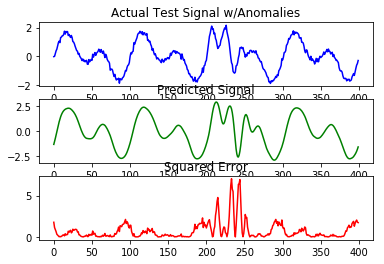

Training duration (s) :  60.323375940322876


(<keras.models.Sequential at 0x1a22ade550>,
 array([-0.03234027, -0.01299899,  0.17696021,  0.37163726,  0.48932391,
         0.72637937,  0.93782884,  1.04655172,  0.94511579,  1.30762295,
         1.3353632 ,  1.4208764 ,  1.43421399,  1.52626842,  1.74629737,
         1.54415277,  1.72848576,  1.69945324,  1.72272295,  1.44364595,
         1.52105484,  1.40199673,  1.30996643,  1.44608385,  1.30062824,
         1.02082758,  0.9835917 ,  0.86424928,  0.68650609,  0.53685679,
         0.3906353 ,  0.35000351,  0.13917691,  0.19648548, -0.00479065,
        -0.08431134, -0.17570223, -0.30625616, -0.19783829, -0.34507165,
        -0.2823547 , -0.39815058, -0.32381145, -0.29085709, -0.55892524,
        -0.56973171, -0.23815655, -0.39330687, -0.29637955, -0.23046068,
        -0.29481457,  0.13347121, -0.06621533,  0.12090256,  0.25305059,
         0.05574722,  0.20679014,  0.270261  ,  0.33594441,  0.48777563,
         0.39347172,  0.27181453,  0.46373086,  0.31536627,  0.19971596,
       

In [1]:


""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.
To can understand how does look the wave dataset, currently working model as sample data and need to fit the dataset from the model,
also need to implement the standardization for the time and also for the variables. 

# data used if for industrial sensor data
# data using additional the intel dataset sensor lab so can see the weather stations data
# hdd drive dataset sensor data need to use as well (is a timeseries so can predict the failure of the events)
"""
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random
import pickle
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function
epochs = 1
batch_size = 50


def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)


def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2


def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean


def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model


def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(0, 700, 500, 1000)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
    print ('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted


run_network()

In [2]:
### new model for lstm for the timeseries dataset from paper, is just 

In [3]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Input sequence
wholeSequence = [[0,0,0,0,0,0,0,0,0,2,1],
                 [0,0,0,0,0,0,0,0,2,1,0],
                 [0,0,0,0,0,0,0,2,1,0,0],
                 [0,0,0,0,0,0,2,1,0,0,0],
                 [0,0,0,0,0,2,1,0,0,0,0],
                 [0,0,0,0,2,1,0,0,0,0,0],
                 [0,0,0,2,1,0,0,0,0,0,0],
                 [0,0,2,1,0,0,0,0,0,0,0],
                 [0,2,1,0,0,0,0,0,0,0,0],
                 [2,1,0,0,0,0,0,0,0,0,0]]

# Preprocess Data:
wholeSequence = np.array(wholeSequence, dtype=float) # Convert to NP array.
data = wholeSequence[:-1] # all but last
target = wholeSequence[1:] # all but first

# Reshape training data for Keras LSTM model
# The training data needs to be (batchIndex, timeStepIndex, dimentionIndex)
# Single batch, 9 time steps, 11 dimentions
data = data.reshape((1, 9, 11))
target = target.reshape((1, 9, 11))

# Build Model
model = Sequential()  
model.add(LSTM(11, input_shape=(9, 11), unroll=True, return_sequences=True))
model.add(Dense(11))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(data, target, nb_epoch=2000, batch_size=1, verbose=2)

/Users/sb/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/2000
1s - loss: 0.3929
Epoch 2/2000
0s - loss: 0.3894
Epoch 3/2000
0s - loss: 0.3862
Epoch 4/2000
0s - loss: 0.3829
Epoch 5/2000
0s - loss: 0.3796
Epoch 6/2000
0s - loss: 0.3765
Epoch 7/2000
0s - loss: 0.3737
Epoch 8/2000
0s - loss: 0.3711
Epoch 9/2000
0s - loss: 0.3686
Epoch 10/2000
0s - loss: 0.3661
Epoch 11/2000
0s - loss: 0.3636
Epoch 12/2000
0s - loss: 0.3613
Epoch 13/2000
0s - loss: 0.3591
Epoch 14/2000
0s - loss: 0.3568
Epoch 15/2000
0s - loss: 0.3545
Epoch 16/2000
0s - loss: 0.3523
Epoch 17/2000
0s - loss: 0.3503
Epoch 18/2000
0s - loss: 0.3483
Epoch 19/2000
0s - loss: 0.3463
Epoch 20/2000
0s - loss: 0.3443
Epoch 21/2000
0s - loss: 0.3423
Epoch 22/2000
0s - loss: 0.3403
Epoch 23/2000
0s - loss: 0.3382
Epoch 24/2000
0s - loss: 0.3362
Epoch 25/2000
0s - loss: 0.3342
Epoch 26/2000
0s - loss: 0.3324
Epoch 27/2000
0s - loss: 0.3308
Epoch 28/2000
0s - loss: 0.3293
Epoch 29/2000
0s - loss: 0.3280
Epoch 30/2000
0s - loss: 0.3267
Epoch 31/2000
0s - loss: 0.3253
Epoch 32/2000
0s 

0s - loss: 0.2310
Epoch 262/2000
0s - loss: 0.2306
Epoch 263/2000
0s - loss: 0.2300
Epoch 264/2000
0s - loss: 0.2295
Epoch 265/2000
0s - loss: 0.2291
Epoch 266/2000
0s - loss: 0.2285
Epoch 267/2000
0s - loss: 0.2280
Epoch 268/2000
0s - loss: 0.2276
Epoch 269/2000
0s - loss: 0.2272
Epoch 270/2000
0s - loss: 0.2269
Epoch 271/2000
0s - loss: 0.2265
Epoch 272/2000
0s - loss: 0.2262
Epoch 273/2000
0s - loss: 0.2259
Epoch 274/2000
0s - loss: 0.2256
Epoch 275/2000
0s - loss: 0.2253
Epoch 276/2000
0s - loss: 0.2249
Epoch 277/2000
0s - loss: 0.2246
Epoch 278/2000
0s - loss: 0.2243
Epoch 279/2000
0s - loss: 0.2239
Epoch 280/2000
0s - loss: 0.2235
Epoch 281/2000
0s - loss: 0.2232
Epoch 282/2000
0s - loss: 0.2228
Epoch 283/2000
0s - loss: 0.2224
Epoch 284/2000
0s - loss: 0.2220
Epoch 285/2000
0s - loss: 0.2217
Epoch 286/2000
0s - loss: 0.2213
Epoch 287/2000
0s - loss: 0.2210
Epoch 288/2000
0s - loss: 0.2205
Epoch 289/2000
0s - loss: 0.2202
Epoch 290/2000
0s - loss: 0.2198
Epoch 291/2000
0s - loss:

0s - loss: 0.1191
Epoch 531/2000
0s - loss: 0.1190
Epoch 532/2000
0s - loss: 0.1187
Epoch 533/2000
0s - loss: 0.1185
Epoch 534/2000
0s - loss: 0.1185
Epoch 535/2000
0s - loss: 0.1182
Epoch 536/2000
0s - loss: 0.1181
Epoch 537/2000
0s - loss: 0.1177
Epoch 538/2000
0s - loss: 0.1176
Epoch 539/2000
0s - loss: 0.1175
Epoch 540/2000
0s - loss: 0.1174
Epoch 541/2000
0s - loss: 0.1170
Epoch 542/2000
0s - loss: 0.1172
Epoch 543/2000
0s - loss: 0.1168
Epoch 544/2000
0s - loss: 0.1165
Epoch 545/2000
0s - loss: 0.1163
Epoch 546/2000
0s - loss: 0.1163
Epoch 547/2000
0s - loss: 0.1160
Epoch 548/2000
0s - loss: 0.1157
Epoch 549/2000
0s - loss: 0.1158
Epoch 550/2000
0s - loss: 0.1156
Epoch 551/2000
0s - loss: 0.1153
Epoch 552/2000
0s - loss: 0.1153
Epoch 553/2000
0s - loss: 0.1149
Epoch 554/2000
0s - loss: 0.1150
Epoch 555/2000
0s - loss: 0.1147
Epoch 556/2000
0s - loss: 0.1144
Epoch 557/2000
0s - loss: 0.1143
Epoch 558/2000
0s - loss: 0.1141
Epoch 559/2000
0s - loss: 0.1138
Epoch 560/2000
0s - loss:

0s - loss: 0.0796
Epoch 787/2000
0s - loss: 0.0795
Epoch 788/2000
0s - loss: 0.0793
Epoch 789/2000
0s - loss: 0.0793
Epoch 790/2000
0s - loss: 0.0793
Epoch 791/2000
0s - loss: 0.0792
Epoch 792/2000
0s - loss: 0.0792
Epoch 793/2000
0s - loss: 0.0791
Epoch 794/2000
0s - loss: 0.0791
Epoch 795/2000
0s - loss: 0.0790
Epoch 796/2000
0s - loss: 0.0789
Epoch 797/2000
0s - loss: 0.0788
Epoch 798/2000
0s - loss: 0.0786
Epoch 799/2000
0s - loss: 0.0789
Epoch 800/2000
0s - loss: 0.0786
Epoch 801/2000
0s - loss: 0.0788
Epoch 802/2000
0s - loss: 0.0787
Epoch 803/2000
0s - loss: 0.0785
Epoch 804/2000
0s - loss: 0.0784
Epoch 805/2000
0s - loss: 0.0785
Epoch 806/2000
0s - loss: 0.0781
Epoch 807/2000
0s - loss: 0.0781
Epoch 808/2000
0s - loss: 0.0781
Epoch 809/2000
0s - loss: 0.0781
Epoch 810/2000
0s - loss: 0.0778
Epoch 811/2000
0s - loss: 0.0779
Epoch 812/2000
0s - loss: 0.0776
Epoch 813/2000
0s - loss: 0.0776
Epoch 814/2000
0s - loss: 0.0776
Epoch 815/2000
0s - loss: 0.0774
Epoch 816/2000
0s - loss:

0s - loss: 0.0587
Epoch 1037/2000
0s - loss: 0.0587
Epoch 1038/2000
0s - loss: 0.0586
Epoch 1039/2000
0s - loss: 0.0586
Epoch 1040/2000
0s - loss: 0.0587
Epoch 1041/2000
0s - loss: 0.0584
Epoch 1042/2000
0s - loss: 0.0583
Epoch 1043/2000
0s - loss: 0.0583
Epoch 1044/2000
0s - loss: 0.0585
Epoch 1045/2000
0s - loss: 0.0580
Epoch 1046/2000
0s - loss: 0.0582
Epoch 1047/2000
0s - loss: 0.0581
Epoch 1048/2000
0s - loss: 0.0580
Epoch 1049/2000
0s - loss: 0.0578
Epoch 1050/2000
0s - loss: 0.0580
Epoch 1051/2000
0s - loss: 0.0578
Epoch 1052/2000
0s - loss: 0.0578
Epoch 1053/2000
0s - loss: 0.0577
Epoch 1054/2000
0s - loss: 0.0576
Epoch 1055/2000
0s - loss: 0.0576
Epoch 1056/2000
0s - loss: 0.0576
Epoch 1057/2000
0s - loss: 0.0575
Epoch 1058/2000
0s - loss: 0.0575
Epoch 1059/2000
0s - loss: 0.0575
Epoch 1060/2000
0s - loss: 0.0575
Epoch 1061/2000
0s - loss: 0.0574
Epoch 1062/2000
0s - loss: 0.0574
Epoch 1063/2000
0s - loss: 0.0574
Epoch 1064/2000
0s - loss: 0.0573
Epoch 1065/2000
0s - loss: 0.0

0s - loss: 0.0464
Epoch 1286/2000
0s - loss: 0.0465
Epoch 1287/2000
0s - loss: 0.0465
Epoch 1288/2000
0s - loss: 0.0462
Epoch 1289/2000
0s - loss: 0.0462
Epoch 1290/2000
0s - loss: 0.0461
Epoch 1291/2000
0s - loss: 0.0459
Epoch 1292/2000
0s - loss: 0.0459
Epoch 1293/2000
0s - loss: 0.0459
Epoch 1294/2000
0s - loss: 0.0459
Epoch 1295/2000
0s - loss: 0.0458
Epoch 1296/2000
0s - loss: 0.0458
Epoch 1297/2000
0s - loss: 0.0457
Epoch 1298/2000
0s - loss: 0.0456
Epoch 1299/2000
0s - loss: 0.0456
Epoch 1300/2000
0s - loss: 0.0455
Epoch 1301/2000
0s - loss: 0.0454
Epoch 1302/2000
0s - loss: 0.0454
Epoch 1303/2000
0s - loss: 0.0453
Epoch 1304/2000
0s - loss: 0.0453
Epoch 1305/2000
0s - loss: 0.0452
Epoch 1306/2000
0s - loss: 0.0451
Epoch 1307/2000
0s - loss: 0.0452
Epoch 1308/2000
0s - loss: 0.0450
Epoch 1309/2000
0s - loss: 0.0449
Epoch 1310/2000
0s - loss: 0.0450
Epoch 1311/2000
0s - loss: 0.0448
Epoch 1312/2000
0s - loss: 0.0448
Epoch 1313/2000
0s - loss: 0.0448
Epoch 1314/2000
0s - loss: 0.0

0s - loss: 0.0330
Epoch 1537/2000
0s - loss: 0.0332
Epoch 1538/2000
0s - loss: 0.0329
Epoch 1539/2000
0s - loss: 0.0327
Epoch 1540/2000
0s - loss: 0.0328
Epoch 1541/2000
0s - loss: 0.0325
Epoch 1542/2000
0s - loss: 0.0327
Epoch 1543/2000
0s - loss: 0.0326
Epoch 1544/2000
0s - loss: 0.0324
Epoch 1545/2000
0s - loss: 0.0325
Epoch 1546/2000
0s - loss: 0.0323
Epoch 1547/2000
0s - loss: 0.0323
Epoch 1548/2000
0s - loss: 0.0322
Epoch 1549/2000
0s - loss: 0.0320
Epoch 1550/2000
0s - loss: 0.0321
Epoch 1551/2000
0s - loss: 0.0320
Epoch 1552/2000
0s - loss: 0.0319
Epoch 1553/2000
0s - loss: 0.0319
Epoch 1554/2000
0s - loss: 0.0317
Epoch 1555/2000
0s - loss: 0.0317
Epoch 1556/2000
0s - loss: 0.0317
Epoch 1557/2000
0s - loss: 0.0317
Epoch 1558/2000
0s - loss: 0.0316
Epoch 1559/2000
0s - loss: 0.0316
Epoch 1560/2000
0s - loss: 0.0314
Epoch 1561/2000
0s - loss: 0.0313
Epoch 1562/2000
0s - loss: 0.0314
Epoch 1563/2000
0s - loss: 0.0312
Epoch 1564/2000
0s - loss: 0.0312
Epoch 1565/2000
0s - loss: 0.0

Epoch 1791/2000
0s - loss: 0.0188
Epoch 1792/2000
0s - loss: 0.0185
Epoch 1793/2000
0s - loss: 0.0185
Epoch 1794/2000
0s - loss: 0.0184
Epoch 1795/2000
0s - loss: 0.0184
Epoch 1796/2000
0s - loss: 0.0184
Epoch 1797/2000
0s - loss: 0.0183
Epoch 1798/2000
0s - loss: 0.0183
Epoch 1799/2000
0s - loss: 0.0181
Epoch 1800/2000
0s - loss: 0.0183
Epoch 1801/2000
0s - loss: 0.0182
Epoch 1802/2000
0s - loss: 0.0183
Epoch 1803/2000
0s - loss: 0.0182
Epoch 1804/2000
0s - loss: 0.0181
Epoch 1805/2000
0s - loss: 0.0180
Epoch 1806/2000
0s - loss: 0.0182
Epoch 1807/2000
0s - loss: 0.0180
Epoch 1808/2000
0s - loss: 0.0179
Epoch 1809/2000
0s - loss: 0.0180
Epoch 1810/2000
0s - loss: 0.0178
Epoch 1811/2000
0s - loss: 0.0179
Epoch 1812/2000
0s - loss: 0.0179
Epoch 1813/2000
0s - loss: 0.0177
Epoch 1814/2000
0s - loss: 0.0176
Epoch 1815/2000
0s - loss: 0.0177
Epoch 1816/2000
0s - loss: 0.0177
Epoch 1817/2000
0s - loss: 0.0176
Epoch 1818/2000
0s - loss: 0.0175
Epoch 1819/2000
0s - loss: 0.0175
Epoch 1820/200

In [4]:
#univariate timeseries for RNN building the model

import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 18:10:31) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [5]:
#import libraries
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


In [6]:
tf.__version__

'1.1.0'

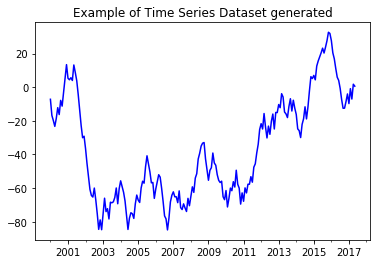

2000-01-31    -7.192573
2000-02-29   -16.800740
2000-03-31   -19.850811
2000-04-30   -23.305307
2000-05-31   -18.589206
2000-06-30   -12.180786
2000-07-31   -16.272643
2000-08-31    -7.833741
2000-09-30   -11.256869
2000-10-31    -3.043423
Freq: M, dtype: float64

In [7]:
random.seed(111)
rng = pd.date_range(start="2000", periods=209, freq="M")
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c="b", title = "Example of Time Series Dataset generated")
plt.show()
ts.head(10)

In [8]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1 #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS)% num_periods ))]
x_batches = x_data.reshape(-1, 20, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

10
(10, 20, 1)
[[[ -7.19257323]
  [-16.80074026]
  [-19.85081064]
  [-23.30530735]
  [-18.58920583]
  [-12.18078607]
  [-16.27264283]
  [ -7.83374055]
  [-11.256869  ]
  [ -3.0434233 ]
  [  4.98191204]
  [ 13.41957504]
  [  5.31647819]
  [  4.41894656]
  [  5.64482136]
  [  3.99382903]
  [ 13.21397086]
  [  8.74448257]
  [  3.81806914]
  [ -4.38984003]]

 [[-13.75733928]
  [-22.82215291]
  [-30.03884875]
  [-29.17934872]
  [-36.46017145]
  [-45.34612166]
  [-53.19496912]
  [-60.74831329]
  [-64.4026527 ]
  [-65.34040611]
  [-59.99742612]
  [-67.05677076]
  [-75.1973327 ]
  [-84.56010298]
  [-78.91927802]
  [-84.77302961]
  [-75.19516368]
  [-66.0259067 ]
  [-74.0046535 ]
  [-72.2630106 ]]]


In [9]:
y_data = TS[1:(len(TS)-(len(TS)% num_periods ))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

print(y_batches[0:1])
print(y_batches.shape)

[[[-16.80074026]
  [-19.85081064]
  [-23.30530735]
  [-18.58920583]
  [-12.18078607]
  [-16.27264283]
  [ -7.83374055]
  [-11.256869  ]
  [ -3.0434233 ]
  [  4.98191204]
  [ 13.41957504]
  [  5.31647819]
  [  4.41894656]
  [  5.64482136]
  [  3.99382903]
  [ 13.21397086]
  [  8.74448257]
  [  3.81806914]
  [ -4.38984003]
  [-13.75733928]]]
(10, 20, 1)


In [10]:
#test dataset creation for testing, we have above the train datasegt

def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 20, 1)
[[[ 23.80683225]
  [ 27.61924061]
  [ 32.68598825]
  [ 31.96420855]
  [ 27.68896896]
  [ 20.42399085]
  [ 16.89729471]
  [ 11.12541872]
  [  5.95166285]
  [  4.03309209]
  [ -0.65363651]
  [ -7.27078072]
  [-12.52843987]
  [-12.47499612]
  [ -8.55417357]
  [ -4.01599731]
  [ -9.75242802]
  [ -0.86934106]
  [ -7.04811966]
  [  1.76276579]]]


# RNN Model Building 

In [11]:
# need to create the model we can use tensorflow or keras backed by tensorflow


In [12]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [13]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 499680.0
100 	MSE: 15994.0
200 	MSE: 7031.81
300 	MSE: 4382.85
400 	MSE: 3185.96
500 	MSE: 2314.09
600 	MSE: 1794.23
700 	MSE: 1579.42
800 	MSE: 1258.24
900 	MSE: 1233.79
[[[  8.59125519]
  [ 46.54821014]
  [ 50.61003113]
  [ 34.9394989 ]
  [ 32.73966217]
  [ 40.4774971 ]
  [ 16.42866516]
  [ 16.2557106 ]
  [ 12.57253551]
  [-11.48920441]
  [-11.06798267]
  [-20.86280823]
  [-39.97878265]
  [-18.60847664]
  [  8.42797756]
  [  4.43144083]
  [ -0.48947978]
  [ 16.28977776]
  [  7.42311954]
  [  2.50633168]]]


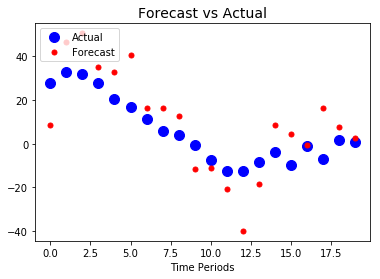

In [14]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()


In [15]:
##### Multivariate timeseries

In [16]:
#data preparation
from pandas import read_csv
from datetime import datetime

In [17]:
# data location
# path: /Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv

In [18]:
df = read_csv('/Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv')

In [19]:
df.head()

,Time,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand
0,0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
1,1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
2,2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
3,3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
4,4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0


In [20]:
# load data
'''
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')
'''

"\ndef parse(x):\n\treturn datetime.strptime(x, '%Y %m %d %H')\ndataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)\ndataset.drop('No', axis=1, inplace=True)\n# manually specify column names\ndataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']\ndataset.index.name = 'date'\n# mark all NA values with 0\ndataset['pollution'].fillna(0, inplace=True)\n# drop the first 24 hours\ndataset = dataset[24:]\n# summarize first 5 rows\nprint(dataset.head(5))\n# save to file\ndataset.to_csv('pollution.csv')\n"

In [21]:
'''# from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('/Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 ]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()'''

"# from pandas import read_csv\nfrom matplotlib import pyplot\n# load dataset\ndataset = read_csv('/Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv', header=0, index_col=0)\nvalues = dataset.values\n# specify columns to plot\ngroups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 ]\ni = 1\n# plot each column\npyplot.figure()\nfor group in groups:\n\tpyplot.subplot(len(groups), 1, i)\n\tpyplot.plot(values[:, group])\n\tpyplot.title(dataset.columns[group], y=0.5, loc='right')\n\ti += 1\npyplot.show()"

In [22]:
ts = read_csv('/Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv', header=0, index_col=0)

/Users/sb/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
ts.head()

,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand
Time,,,,,,,,,,,,,,,,,,,
0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0


In [24]:
'''import matplotlib.pyplot as plt
%matplotlib inline

ts_test = ts.cumsum()

ts_test.plot()'''

'import matplotlib.pyplot as plt\n%matplotlib inline\n\nts_test = ts.cumsum()\n\nts_test.plot()'

In [25]:
values = ts.values


In [26]:
ts.head()

,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand
Time,,,,,,,,,,,,,,,,,,,
0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3364d710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a28569ba8>], dtype=object)

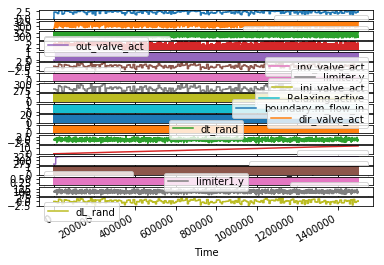

In [27]:
ts.plot(subplots=True)

In [28]:

from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('/Users/sb/Desktop/Lab/DataIoT/GHL/train_1500000_seed_11_vars_23.csv', header=0, index_col=0)


/Users/sb/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
dataset.head()

,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand
Time,,,,,,,,,,,,,,,,,,,
0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0


In [30]:
list(dataset)

['RT_level_ini',
 'RT_temperature.T',
 'HT_temperature.T',
 'RT_level',
 'out_valve_act',
 'dT_rand',
 'inv_valve_act',
 'limiter.y',
 'inj_valve_act',
 'Relaxing.active',
 'boundary.m_flow_in',
 'dir_valve_act',
 'dt_rand',
 'C_level',
 'C_temperature.T',
 'heater_act',
 'HT_level',
 'limiter1.y',
 'dL_rand']

In [31]:
values = dataset.values
# specify columns to plot
#groups = [0, 1, 2, 3, 5, 6, 7]
values

array([[  0.00000000e+00,   2.83149994e+02,   2.83149994e+02, ...,
          1.00000001e-01,   1.00000000e+02,   0.00000000e+00],
       [  0.00000000e+00,   2.83149994e+02,   2.83163330e+02, ...,
          1.00000001e-01,   1.00000000e+02,   0.00000000e+00],
       [  0.00000000e+00,   2.83149994e+02,   2.83176666e+02, ...,
          1.00000001e-01,   1.00000000e+02,   0.00000000e+00],
       ..., 
       [  2.41876745e+00,   2.95441437e+02,   3.00915436e+02, ...,
          6.00000024e-01,   9.77272873e+01,   3.37534726e-01],
       [  2.41876745e+00,   2.95441437e+02,   3.00952850e+02, ...,
          6.00000024e-01,   9.77272873e+01,   3.37534726e-01],
       [  2.41876745e+00,   2.95441437e+02,   3.00952850e+02, ...,
          6.00000024e-01,   9.77272873e+01,   3.37534726e-01]])

In [32]:
groups = [0, 1, 2, 3, 5, 6, 7]
groups

[0, 1, 2, 3, 5, 6, 7]

In [33]:
'''values = dataset.values
# specify columns to plot
groups = list(dataset)
i = 1
# plot each column
pyplot.figure()
for group in groups:
	#pyplot.subplot(len(groups), 1, i)
	pyplot.plot(dataset[group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

fig, ax = plt.subplots()
dataset.plot(ax=ax)
pyplot.show()
fig.savefig("x.png")'''

'values = dataset.values\n# specify columns to plot\ngroups = list(dataset)\ni = 1\n# plot each column\npyplot.figure()\nfor group in groups:\n\t#pyplot.subplot(len(groups), 1, i)\n\tpyplot.plot(dataset[group])\n\tpyplot.title(dataset.columns[group], y=0.5, loc=\'right\')\n\ti += 1\npyplot.show()\n\nfig, ax = plt.subplots()\ndataset.plot(ax=ax)\npyplot.show()\nfig.savefig("x.png")'

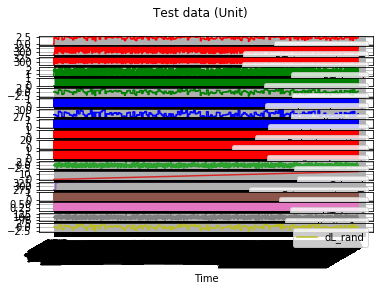

In [ ]:
# Plotting
import numpy as np

dataset.plot(kind='line', subplots=True, grid=True, title="Test data (Unit)",
    layout=(19, 1), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
    xticks=np.arange(0, len(dataset), 16))

[ax.legend(loc=1) for ax in plt.gcf().axes]

In [ ]:
# Plotting
import numpy as np

dataset.plot(kind='line', subplots=True, grid=True, title="Test data (Unit)",
    layout=(19, 1), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
    xticks=np.arange(0, len(dataset), 16))

In [ ]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)


In [ ]:
##### pandas working example 

for i in dataset.columns:
    ax=plt.subplot(2,1,i+1) 
    df[[i]].plot(ax=ax)
    print(i)
plt.show()



In [ ]:
#### Data prep for LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# model evaluation
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)